# COVID-19 - Creating a Crawler for get information from wikipedia

In [23]:
# import the BeautifulSoup library so we can parse HTML and XML documents
from bs4 import BeautifulSoup
import urllib.request
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
pd.options.display.max_rows=1000
import re

## Trying to figure out what class we need to search in order to bring the table that we want

In [24]:
# specify which URL/web page we are going to be scraping
url = "https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Brazil"

# open the url using urllib.request and put the HTML into the page variable
page = urllib.request.urlopen(url)

# parse the HTML from our URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page, "lxml")

In [25]:
#print(soup.prettify())

In [26]:
#print(soup.title.string)

In [27]:
all_tables=soup.find_all("span")
#all_tables

In [28]:
soup.find_all("td", {"class":"bb-04em"})[0]

<td class="bb-04em" colspan="2" style="text-align:center">2020-02-26</td>

In [29]:
#for table in soup.find_all("td", {"class":"bb-04em"}):
    #print(table)

In [30]:
soup.find("span", {"class": "cbs-ibr"})

<span class="cbs-ibr" style="padding:0 0.3em 0 0; width:3.5em">1</span>

In [31]:
soup.find("span", {"class": "cbs-ibr"}).get_text(strip=True)

'1'

In [32]:
#for table in soup.find_all("span", {"class":"cbs-ibl"}):
    #print(table)

## Function to get information of wikipedia pages,process and create dataframe

In [33]:
def create_df(url):

    # specify which URL/web page we are going to be scraping
    url = url

    # open the url using urllib.request and put the HTML into the page variable
    page = urllib.request.urlopen(url)

    # parse the HTML from our URL into the BeautifulSoup parse tree format
    soup = BeautifulSoup(page, "lxml")
    
    # creating list for store the dates found in class bb-04em
    list_dates = []
    for table in soup.find_all("td", {"class":"bb-04em"}):
        list_dates.append(str(table))
        
    list_dates_values = []
    for i in list_dates:
        date = re.search(r'>(.*?)<', i)
        list_dates_values.append(date.group(1))

    from itertools import compress

    list_dates_values_2 = []
    for i in list_dates_values:
        date2 = i.startswith(tuple(['2020','⋮']))
        list_dates_values_2.append(date2)

    list_dates_final = list(compress(list_dates_values, list_dates_values_2))

    # creating list for store the amount of COVID-19 cases found in class cbs-ibr
    list_ibr = []
    for table in soup.find_all("span", {"class":"cbs-ibr"}):
        list_ibr.append(str(table))

    list_ibr_values = []
    for i in list_ibr:
        number = re.search(r'>(.*?)<', i)
        list_ibr_values.append(number.group(1))
    
    list_ibr_cases = list_ibr_values[0::2]
    list_ibr_deaths = list_ibr_values[1::2]

    # creating list for store the amount of COVID-19 deaths found in class cbs-ibr
    list_ibl = []
    for table in soup.find_all("span", {"class":"cbs-ibl"}):
        list_ibl.append(str(table))

    list_ibl_values = []
    for i in list_ibl:
        number = re.search(r'>(.*?)<', i)
        list_ibl_values.append(number.group(1))

    pct_increased_cases = list_ibl_values[0::2]
    pct_increased_deaths = list_ibl_values[1::2]
    
    # creating the dataframe with the values that we got before
    df = pd.DataFrame(data={'Date':list_dates_final,
                            '# Cases':list_ibr_cases, 
                            '% Increase in Cases': pct_increased_cases,
                            '# Deaths': list_ibr_deaths,
                            '% Increase in Deaths': pct_increased_deaths
                           })

    return df

## Brazil and USA cases of COVID-19 

In [34]:
url_br = "https://en.wikipedia.org/wiki/COVID-19_pandemic_in_Brazil"
df_br = create_df(url_br)
df_br.head()
print(df_br.shape)

(74, 5)


In [35]:
url_usa = "https://en.wikipedia.org/wiki/COVID-19_pandemic_in_the_United_States"
df_usa = create_df(url_usa)
df_usa.head()
print(df_usa.shape)

(95, 5)


## Dataprep for create the graphs

### Selecting the same period

In [36]:
df_br = df_br[4:]
df_br.head()
print(df_br.shape)

df_usa = df_usa[25:]
df_usa.head()
print(df_usa.shape)


(70, 5)
(70, 5)


### Transforming date object in datetime

In [37]:
df_br['Date'] = pd.to_datetime(df_br['Date'])
df_usa['Date'] = pd.to_datetime(df_usa['Date'])

### Replacing the empty death cases of Brazil to zero

In [38]:
df_br['# Deaths'][:13] = df_br['# Deaths'][:13].str.replace('', '0')

### Replacing comma and Transforming strings in int 

In [39]:
df_br['# Deaths'] = df_br['# Deaths'].str.replace(',', '')
df_br['# Deaths'] = df_br['# Deaths'].astype(int)

df_br['# Cases'] = df_br['# Cases'].str.replace(',', '')
df_br['# Cases'] = df_br['# Cases'].astype(int)

df_usa['# Deaths'] = df_usa['# Deaths'].str.replace(',', '')
df_usa['# Deaths'] = df_usa['# Deaths'].astype(int)

df_usa['# Cases'] = df_usa['# Cases'].str.replace(',', '')
df_usa['# Cases'] = df_usa['# Cases'].astype(int)

## Graph creation

In [40]:
%matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker

import pandas as pd
import numpy as np

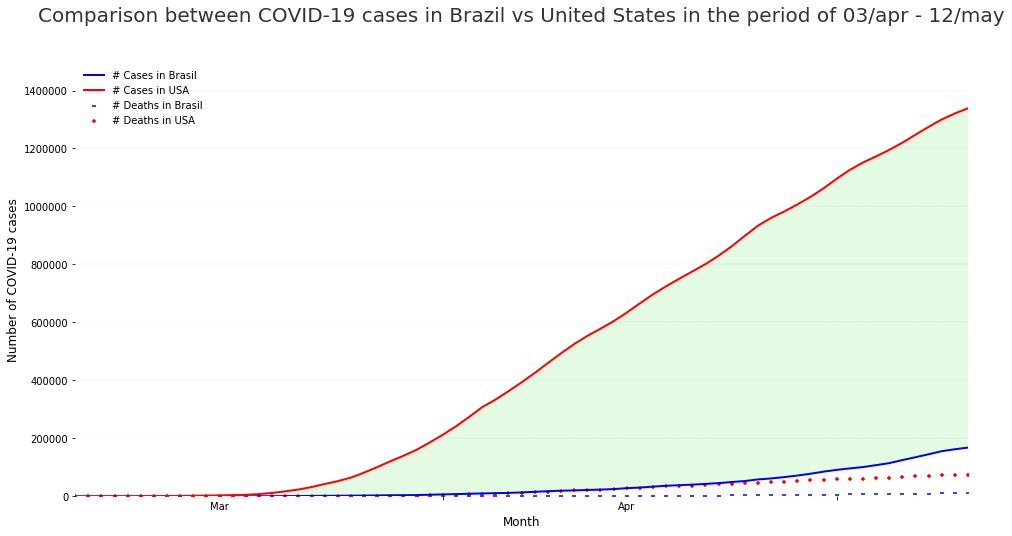

In [41]:
date_index = np.arange('2020-03-04','2020-05-13', dtype='datetime64[D]')

plt.figure(figsize=(16, 8))

plt.plot(date_index,df_br['# Cases'],color='blue', linewidth=2, alpha=1) 
plt.plot(date_index,df_usa['# Cases'],color='red', linewidth=2, alpha=1)
plt.scatter(date_index,df_br['# Deaths'], color='blue', s=10, marker='_')
plt.scatter(date_index,df_usa['# Deaths'], color='red', s=10, marker='+')

ax = plt.gca()
ax.axis(['2020-03-04','2020-05-11',0,1500000])

plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of COVID-19 cases', fontsize=12)
plt.title('Comparison between COVID-19 cases in Brazil vs United States in the period of 03/apr - 12/may',
          size=20, 
          alpha=0.8, 
          pad=40)
plt.legend(['# Cases in Brasil','# Cases in USA','# Deaths in Brasil','# Deaths in USA'],frameon=False)
  
ax.fill_between(date_index, df_br['# Cases'], df_usa['# Cases'], facecolor='lightgreen', alpha=0.25)

ax.xaxis.set_major_locator(dates.MonthLocator())
ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=15))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

ax.set_facecolor('white')

for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')
    
for spine in ax.spines.values():
    spine.set_visible(False)
pos = [200000,400000, 600000, 800000, 1000000, 1200000, 1400000]
plt.hlines(pos, *ax.get_xlim(), color='b', linestyles='--', lw=0.3, alpha=0.2)


This comparison is with a fixed date period, which is between 03/04/2020-12/05/2020. For this reason, it is necessary to have in mind that the COVID-19 cases starts before on USA than in Brazil, so it is not possible to compare as they start in the same day. THe graph above shows that we can mislead the reader if we do not provide and clarify all the informations.